# Citibike Demand Analysis

In this notebook we'll cover the following:
- Analyze Citibike ride data to provide a fundamental understanding of the dataset
- Establish key findings and relationships from the data
- Build a demand model that can predict demand for bikes

# Notebook/Data Setup

First we need to get installations and imports out of the way, as well as load the data. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import ssl

The data is available in S3 here: https://s3.amazonaws.com/tripdata/index.html

Each file in the S3 bucket is 1 month of data with the filename formatted like YYYYMM-citibike-tripdata.csv.zip.

Each file is a zip file, but pandas can read csv from a zip file so no need to worry about unpacking the files. 

As a note, Python 3.6+ on OSx will have certificate issues trying to access the url without creating an unverified context using the ssl module. I'm using a mac to do this project, so code is included. 

In [15]:
data = pd.read_csv('https://s3.amazonaws.com/tripdata/202104-citibike-tripdata.csv.zip', nrows=3)
data.head()

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['202104-citibike-tripdata.csv', '__MACOSX/._202104-citibike-tripdata.csv']

## High level data overview

First we'll just check out what the data looks like before getting into some actual exploration.

In [3]:
data_sample.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,FB6B89D05B67EBED,classic_bike,2021-08-24 15:59:57,2021-08-24 16:42:07,Broadway & E 21 St,6098.10,Central Park North & Adam Clayton Powell Blvd,7617.07,40.739888,-73.989586,40.799484,-73.955613,member
1,E13DA3E30CEF8DFC,classic_bike,2021-08-18 13:12:01,2021-08-18 13:21:26,E 13 St & 2 Ave,5820.08,Henry St & Grand St,5294.04,40.731539,-73.985302,40.714211,-73.981095,member
2,56617490AB8AE69C,classic_bike,2021-08-17 14:31:23,2021-08-17 14:35:34,E 95 St & 3 Ave,7365.13,E 84 St & Park Ave,7243.04,40.784903,-73.950503,40.778627,-73.957721,member
3,CA908B271C7D6663,classic_bike,2021-08-11 10:00:12,2021-08-11 10:31:01,Madison Ave & E 82 St,7188.13,E 84 St & Park Ave,7243.04,40.778131,-73.960694,40.778627,-73.957721,casual
4,3E170CE1F4FE179D,classic_bike,2021-08-12 19:28:38,2021-08-12 19:48:50,E 74 St & 1 Ave,6953.08,E 84 St & Park Ave,7243.04,40.768974,-73.954823,40.778627,-73.957721,casual


In [4]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             10 non-null     object 
 1   rideable_type       10 non-null     object 
 2   started_at          10 non-null     object 
 3   ended_at            10 non-null     object 
 4   start_station_name  10 non-null     object 
 5   start_station_id    10 non-null     float64
 6   end_station_name    10 non-null     object 
 7   end_station_id      10 non-null     float64
 8   start_lat           10 non-null     float64
 9   start_lng           10 non-null     float64
 10  end_lat             10 non-null     float64
 11  end_lng             10 non-null     float64
 12  member_casual       10 non-null     object 
dtypes: float64(6), object(7)
memory usage: 1.1+ KB


So the data is pretty intutive. Each ride has a unique id, and some geographic information about the ride. Additionally we can see whether the rider has a citibike membership or is paying for one-time trip (casual). 

Now we can load more data, though memory may be an issue for my machine with this much data. We can create a data load function that constrains memory used. By only taking a sample of each CSV loaded, peak memory use will be limited to the largest CSV file loaded, rather than the size of all CSVs loaded together (unless a large enough sample size per file is used that would exceed the largest single CSV). 

In [5]:
# Create function for optimized data load
def load_data(use_sample=False):
    """
    Load all files within the data folder at the root of this project (repo) folder. 
    """
    # Use relative filepath to access data
    # glob gets all the csv files in the data directory
    files = glob.glob("../data/*.csv")
    
    # Read all csvs into dataframes, add to a list, and concat list
    all_frames = []
    for f in files:
        data = pd.read_csv(f, 
                           parse_dates=['started_at', 'ended_at'],
                           infer_datetime_format=True,
                           cache_dates=True)
        if use_sample == True:
            data = data.sample(100000, random_state=0)
        all_frames.append(data)
        
    data = pd.concat(all_frames)
        
    return data

    
data = load_data(use_sample=True)

/var/folders/yb/nf2crlgx1kdgc_cpn2rkwzfm0000gn/T/ipykernel_2678/1855619808.py:26: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  data = load_data(use_sample=True)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 36920 to 841536
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             200000 non-null  object        
 1   rideable_type       200000 non-null  object        
 2   started_at          200000 non-null  datetime64[ns]
 3   ended_at            200000 non-null  datetime64[ns]
 4   start_station_name  199996 non-null  object        
 5   start_station_id    199996 non-null  float64       
 6   end_station_name    199081 non-null  object        
 7   end_station_id      199081 non-null  object        
 8   start_lat           200000 non-null  float64       
 9   start_lng           200000 non-null  float64       
 10  end_lat             199520 non-null  float64       
 11  end_lng             199520 non-null  float64       
 12  member_casual       200000 non-null  object        
dtypes: datetime64[ns](2), flo

200k total rows with 100k rows per month, with a memory use of < 22mb. That's a good start. 

# Data Exploration

First we need to have a look at the data for cleanliness. 

From the .info() description above, we can immediately see there are some columns with fewer values than others. We'll check those out first. Let's start with a nulls heatmap. 

<AxesSubplot:>

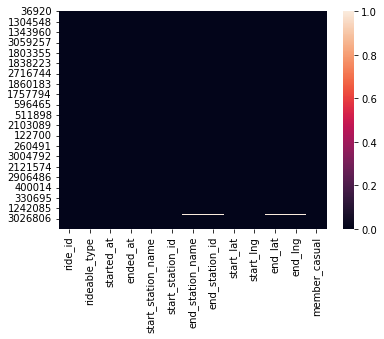

In [7]:
sns.heatmap(data.isnull())

So a small number of nulls, related to the start and end stations and latitudes. From the dataframe information, there are more related to end stations so let's check those out. 

In [8]:
print(len(data.loc[data['end_station_id'].isnull()]))
data.loc[data['end_station_id'].isnull()].head(3)

919


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1619708,417FB80E894A4788,classic_bike,2021-09-20 14:25:46,2021-09-20 15:22:24,27 St & Hunter St,6310.06,NaN,NaN,40.748500,-73.941275,NaN,NaN,member
1578912,98A4DAB36A9ED500,classic_bike,2021-09-04 19:07:58,2021-09-04 19:21:32,W 42 St & 6 Ave,6517.08,NaN,NaN,40.754920,-73.984550,40.75,-73.98,member
1624855,5C5511EAD2B197B2,classic_bike,2021-09-13 15:04:49,2021-09-13 15:57:23,W 47 St & 6 Ave,6667.04,NaN,NaN,40.758397,-73.982550,40.78,-73.98,casual


919 rides with no end station - those rides are no good to us and it's not reasonable to attempt imputing likely end stations when we have very few nulls compared to the greater dataset. We'll drop those rows. 

In [9]:
data.dropna(subset=['start_station_name', 
                    'start_station_id', 
                    'end_station_name', 
                    'end_station_id',
                    'end_lat',
                    'end_lng'], 
            inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199081 entries, 36920 to 841536
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             199081 non-null  object        
 1   rideable_type       199081 non-null  object        
 2   started_at          199081 non-null  datetime64[ns]
 3   ended_at            199081 non-null  datetime64[ns]
 4   start_station_name  199081 non-null  object        
 5   start_station_id    199081 non-null  float64       
 6   end_station_name    199081 non-null  object        
 7   end_station_id      199081 non-null  object        
 8   start_lat           199081 non-null  float64       
 9   start_lng           199081 non-null  float64       
 10  end_lat             199081 non-null  float64       
 11  end_lng             199081 non-null  float64       
 12  member_casual       199081 non-null  object        
dtypes: datetime64[ns](2), flo

All columns now the same length. Now let's do a few other checks on the data:

- Is the member_casual column 100% strings matching "member" or "casual"?
- Check lat/lons for "unreasonable" values". 

In [10]:
# Get percentage of member_casual values that match the correct strings
member_casual_data_length = len(data.loc[data['member_casual'].isin(['member', 'casual'])])
print(f'member_casual count %: {(member_casual_data_length / len(data)) * 100}')

member_casual count %: 100.0


In [11]:
# Check lat long values for integrity
# Get the min and maxes and make sure they are reasonable for NYC
data[['start_lat', 'start_lng', 'end_lat', 'end_lng']].describe().loc[['min', 'max']]

,start_lat,start_lng,end_lat,end_lng
min,40.633385,-74.027472,40.633385,-74.071455
max,40.882260,-73.881450,40.882260,-73.881450


So all the ride coordinates are within reasonable ranges and the member casual column is good to go. 